In [1]:
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# CONSTANTES
BATCH_SIZE = 64
IMG_SIZE = 32
NUM_CLASSES = 10  # nº classes para identificar
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
DENSE_LAYERS = [256, 512, 1024, 1024]

In [3]:
# Define directories
train_dirs = ['./dataset/train/train1', './dataset/train/train2',
              './dataset/train/train3', './dataset/train/train5']
validation_dir = './dataset/validation'
test_dir = './dataset/test'

# Data Augmentation

Testámos vários tipos de data augmentation, com mais e menos intensidade. Concluímos que os valores escolhidos (rotações de 15 graus, deslocamentos horizontais e verticais de 0,01 e horizontal_flip) proporcionavam os melhores resultados, mesmo que essa melhora seja tão pouco significativa que nos deixe a pensar se efetivamente compensa de todo este tempo extra de treino.

Chegamos à conclusão que dado que as imagens do dataset têm baixa resolução, adicionar demasiada data augmentation prejudicava os resultados. Isto ocorre porque transformações excessivas em imagens de baixa qualidade podem distorcer os dados de forma significativa, dificultando a capacidade do modelo de aprender características relevantes. Portanto, um equilíbrio cuidadoso foi necessário para melhorar a robustez do modelo sem comprometer a integridade dos dados visuais.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.01,
    height_shift_range=0.01,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# training generators
train_generators = [train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical') for train_dir in train_dirs]

# Necessário para junstar os trainning generators


def combined_generator(generators):
    while True:
        for generator in generators:
            yield next(generator)


train_generator = combined_generator(train_generators)

# Validation e test generators
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


Teste com outras intensidades de data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.01,
    zoom_range=0.01,
    horizontal_flip=True,
    fill_mode='nearest')

Validation Accuracy Obtida: 0.8462539911270142

---------------------------------------

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    height_shift_range=0.01,
    horizontal_flip=True,
    fill_mode='nearest')

Validation Accuracy Obtida: 0.8409455418586731

---------------------------------------

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=2,
    width_shift_range=0.01,
    horizontal_flip=True,
    fill_mode='nearest')

Validation Accuracy Obtida: 0.8501634340286255

In [5]:


class Precision(Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(
            name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.predicted_positives.assign_add(K.sum(y_pred))

    def result(self):
        return self.true_positives / (self.predicted_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)


class Recall(Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.actual_positives = self.add_weight(name='ap', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.actual_positives.assign_add(K.sum(y_true))

    def result(self):
        return self.true_positives / (self.actual_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.actual_positives.assign(0)


class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [6]:
model = Sequential([
    Conv2D(DENSE_LAYERS[0], (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(DENSE_LAYERS[1], (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Conv2D(DENSE_LAYERS[2], (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(DENSE_LAYERS[3]),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 512)       1

In [7]:
# Definir os Callbacks

# Para salvar o melhor modelo com base na acurácia de validação
checkpoint = ModelCheckpoint(
    "models/modelo_S_com_data_augmentation_adam.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Parar o treinamento se não houver melhoria na loss após x epochs
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Salvar para csv
csv_logger = CSVLogger(
    f'logs/modelo_S_com_data_augmentation_adam.csv', append=True)

# Reduzir a learning rate se não houver melhoria na loss após x epochs (lembrar de deixar este valor sempre menor que a patience no early_stopping!!)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [8]:
# Calculate steps per epoch
steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr]
)

# Evaluate the model
# Evaluate the model
results = model.evaluate(test_generator)
loss, accuracy, precision, recall, f1_score = results[:5]
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")

Epoch 1/100
624/624 [==============================] - ETA: 0s - loss: 1.6637 - accuracy: 0.4272 - precision: 0.5460 - recall: 0.2850 - f1_score: 0.3745

c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric Precision implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric Recall implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_accuracy improved from -inf to 0.51332, saving model to models\modelo_S_com_data_augmentation_adam.keras
624/624 [==============================] - 64s 86ms/step - loss: 1.6637 - accuracy: 0.4272 - precision: 0.5460 - recall: 0.2850 - f1_score: 0.3745 - val_loss: 1.3844 - val_accuracy: 0.5133 - val_precision: 0.7241 - val_recall: 0.3057 - val_f1_score: 0.4299 - lr: 0.0010
Epoch 2/100
624/624 [==============================] - ETA: 0s - loss: 1.2339 - accuracy: 0.5618 - precision: 0.6893 - recall: 0.4292 - f1_score: 0.5290
Epoch 2: val_accuracy improved from 0.51332 to 0.58664, saving model to models\modelo_S_com_data_augmentation_adam.keras
624/624 [==============================] - 41s 65ms/step - loss: 1.2339 - accuracy: 0.5618 - precision: 0.6893 - recall: 0.4292 - f1_score: 0.5290 - val_loss: 1.1930 - val_accuracy: 0.5866 - val_precision: 0.6948 - val_recall: 0.4849 - val_f1_score: 0.5712 - lr: 0.0010
Epoch 3/100
623/624 [============================>.] - ETA: 0s - lo

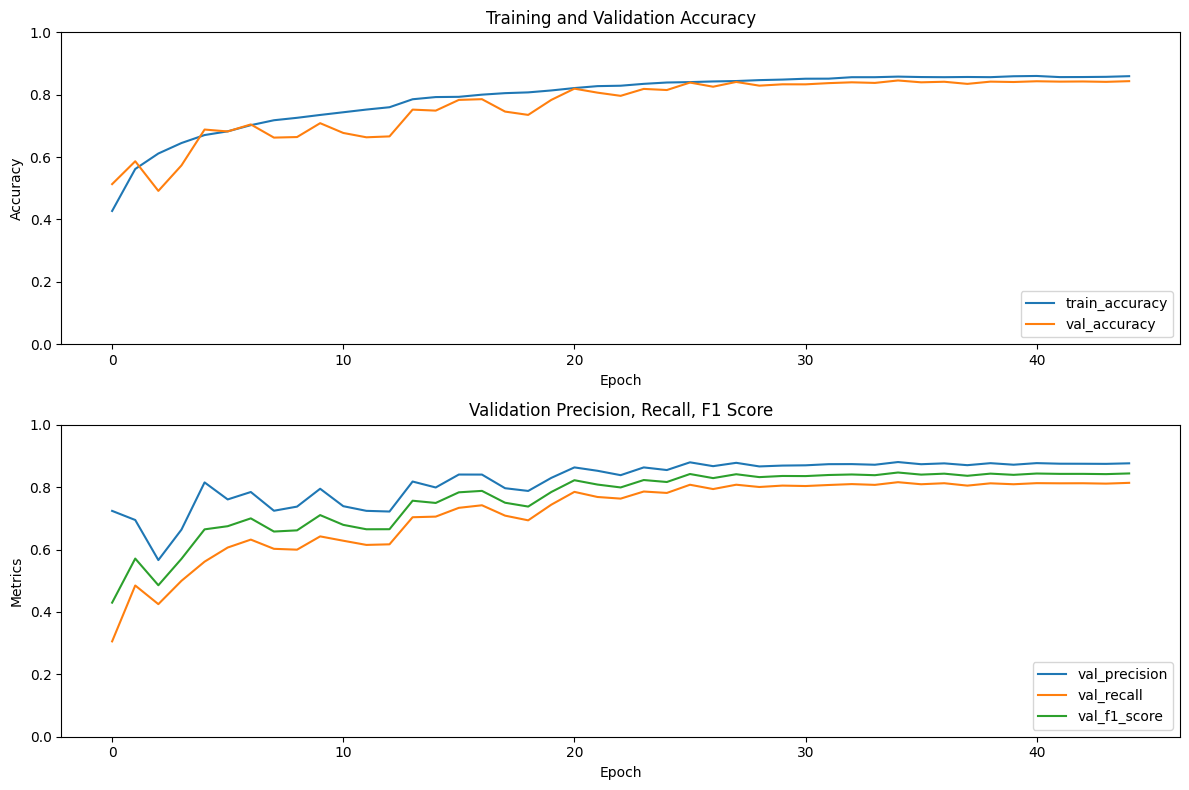

In [9]:
# Plot training history
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['val_precision'], label='val_precision')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Validation Precision, Recall, F1 Score')

plt.savefig(
    f'./plots/modelo_S_com_data_augmentation_adam.png')
plt.tight_layout()